In [2]:
import LinearAlgebra as la
using BenchmarkTools: @btime
include("hoSystem.jl");

## Calculating integrals and basis elements

In [3]:
l_0 = 10   # number of basis functions
ω = 0.25  # strength of harmonic oscillator potential
a = 0.25  # shielding term in coloumb interaction
grid = [x for x in range(-10, stop = 10, length = 2001)]
n = 2     # number of particles

@time system = System(n, HOBasis(l_0, ω, a), grid);

  1.860306 seconds (5.22 M allocations: 306.335 MiB, 5.57% gc time, 5.14% compilation time)


## Hartree-Fock Calculation

In [4]:
function getP(C, n)
    l = size(C)[1]
    P = ComplexF64.(la.zeros((l, l)))
    
    for a in 1:l
        for b in 1:l
            for i in 1:n
                P[b, a] += conj(C[a, i]) * C[b, i]
            end
        end
    end
    return P
end

function getF(C, h, u, n)
    l = size(C)[1]
    F = ComplexF64.(la.zeros((l, l)))
    P = getP(C, n)
    
    F .+= h
    for a in 1:l
        for b in 1:l
            for c in 1:l
                for d in 1:l
                    F[a, b] += P[d, c] * u[a, c, b, d]
                end
            end
        end
    end
    return F
end

getF (generic function with 1 method)

In [5]:
function SCF(C, system, iters)
    for i in 1:iters
        F = getF(C, system.h, system.u, system.n)
        C = la.eigvecs(F)
    end
    return C
end

SCF (generic function with 1 method)

In [6]:
C_initial = ComplexF64.(la.I(system.l))

C = SCF(C_initial, system, 20);
#C_GHF = SCF(C_initial, system, 20000)

## Results

In [7]:
import FileIO
import Plots as plt
import Colors
plt.pyplot()

Plots.PyPlotBackend()

In [8]:
ψ = [abs.(i).^2 for i in (system.spfs .* C[:, 1])] .+ [abs.(i).^2 for i in (system.spfs .* C[:, 2])]
ψ = sum(ψ);

(574, 797)

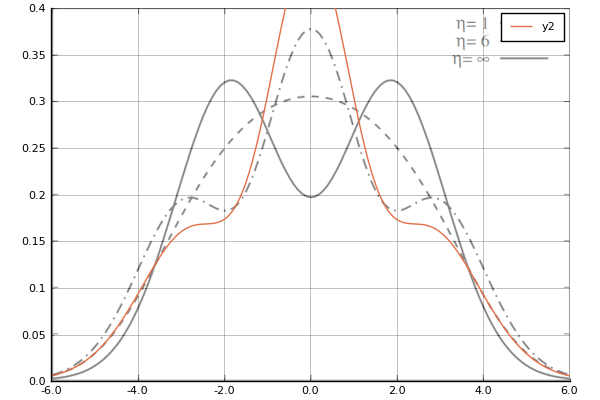

In [136]:
alpha = 0.5
img = FileIO.load("Images/GS.PNG") .- Colors.RGBA(0, 0, 0, 1 - alpha)
plt.plot(img,
         xlim = (0, 797),
         ylim = (0, 574),
         yticks = 574 .- [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4] .* 574 ./ 0.4,
         xticks = ([x for x in -6:2:6] .+ 6) .* 797 ./ 12,
         grid = true, gridalpha = 0.7,
         size = (600, 400),
         xformatter = x -> round((x / 797 - 0.5) * 12, digits = 1),
         yformatter = y -> round((-y / 574 * 0.4 + 0.4), digits = 10),
         )

plt.plot!((grid .+ 6) .* 797 ./ 12, 574 .- ψ .* 574 ./ 0.4)